In [1]:
import pandas as pd 
import glob

# Test

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Đọc file TIFF
file_path = '/mnt/storage/NDVIReconstruct/BRIOS/Data4BRIOS/rvi_8days/rvi_8days_2022-10-01.tif'
img = Image.open(file_path)
img_array = np.array(img)

# Trực quan hóa
plt.figure(figsize=(10, 10))
plt.imshow(img_array, cmap='gray')
plt.colorbar()
plt.title("TIFF Image Visualization")
plt.show()

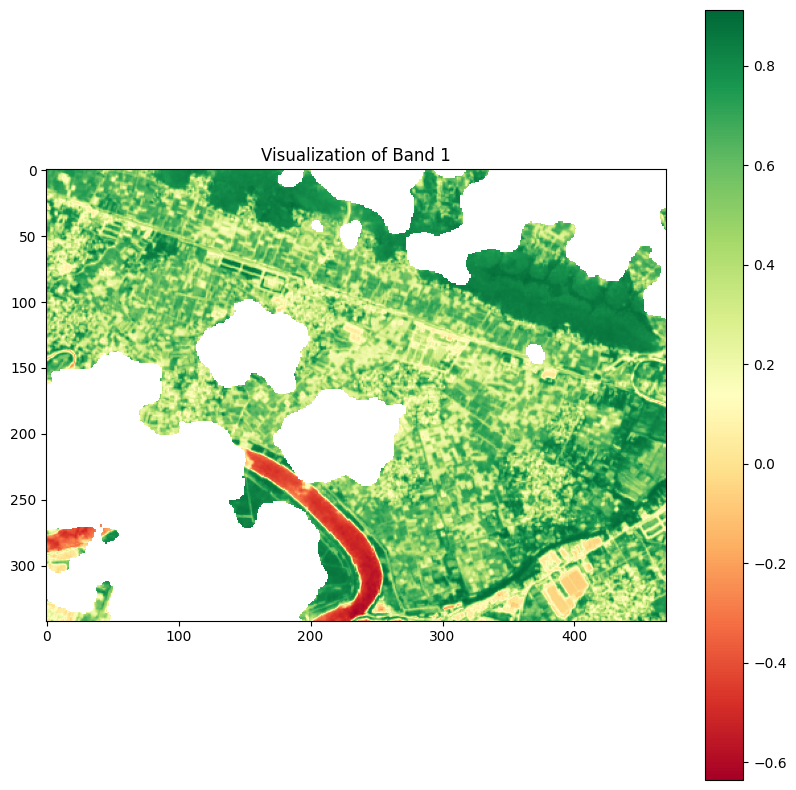

In [26]:
import rasterio
import matplotlib.pyplot as plt

# Đọc file TIFF
file_path = '/mnt/storage/NDVIReconstruct/BRIOS/Data4BRIOS/ndvi_8days/ndvi8days_2022-10-01.tif'
with rasterio.open(file_path) as src:
    band1 = src.read(1)  # Đọc kênh đầu tiên
    # band2 = src.read(2)  # Đọc kênh thứ hai

# Trực quan hóa kênh đầu tiên
plt.figure(figsize=(10, 10))
plt.imshow(band1, cmap='RdYlGn')
plt.colorbar()
plt.title("Visualization of Band 1")
plt.show()


In [30]:
band1.shape[0] * band1.shape[1]

160740

In [33]:
from datetime import datetime, timedelta

start_date = datetime(2022, 10, 1)
end_date = datetime(2023, 10, 1)

date_strings = []

current_date = start_date
while current_date <= end_date:
    date_strings.append(current_date.strftime("%Y-%m-%d"))  
    current_date += timedelta(days=8)  

print(date_strings)

['2022-10-01', '2022-10-09', '2022-10-17', '2022-10-25', '2022-11-02', '2022-11-10', '2022-11-18', '2022-11-26', '2022-12-04', '2022-12-12', '2022-12-20', '2022-12-28', '2023-01-05', '2023-01-13', '2023-01-21', '2023-01-29', '2023-02-06', '2023-02-14', '2023-02-22', '2023-03-02', '2023-03-10', '2023-03-18', '2023-03-26', '2023-04-03', '2023-04-11', '2023-04-19', '2023-04-27', '2023-05-05', '2023-05-13', '2023-05-21', '2023-05-29', '2023-06-06', '2023-06-14', '2023-06-22', '2023-06-30', '2023-07-08', '2023-07-16', '2023-07-24', '2023-08-01', '2023-08-09', '2023-08-17', '2023-08-25', '2023-09-02', '2023-09-10', '2023-09-18', '2023-09-26']


In [36]:
import glob
arr = glob.glob('/mnt/storage/NDVIReconstruct/BRIOS/Data4BRIOS/ndvi_8days/ndvi8days_*.tif')

In [42]:
arr_rvi = glob.glob('/mnt/storage/NDVIReconstruct/BRIOS/Data4BRIOS/rvi_8days/rvi_8days_*.tif')

In [38]:
list_day_in_arr = [x.split('.')[0][-10:] for x in arr]

In [43]:
list_day_in_arr1 = [x.split('.')[0][-10:] for x in arr_rvi]

In [34]:
def check_null_day(arr):
    day_miss = []
    for day in date_strings:
        if day not in arr:
            day_miss.append(day)
    return day_miss

In [40]:
day_miss_arr = check_null_day(list_day_in_arr)

In [41]:
day_miss_arr

['2023-01-05',
 '2023-02-06',
 '2023-02-14',
 '2023-03-26',
 '2023-04-03',
 '2023-04-11',
 '2023-04-19',
 '2023-04-27']

In [44]:
day_miss_arr_rvi = check_null_day(list_day_in_arr1)

In [45]:
day_miss_arr_rvi

[]

# EDA

Distribution 

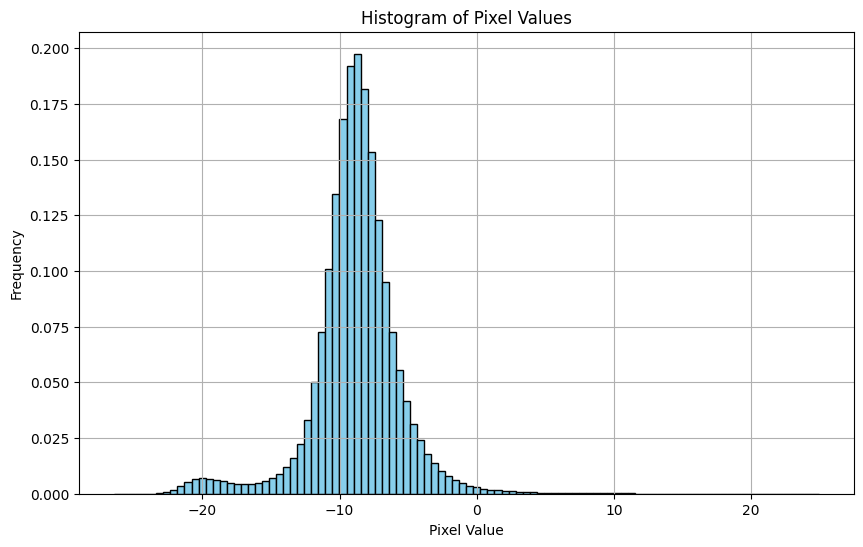

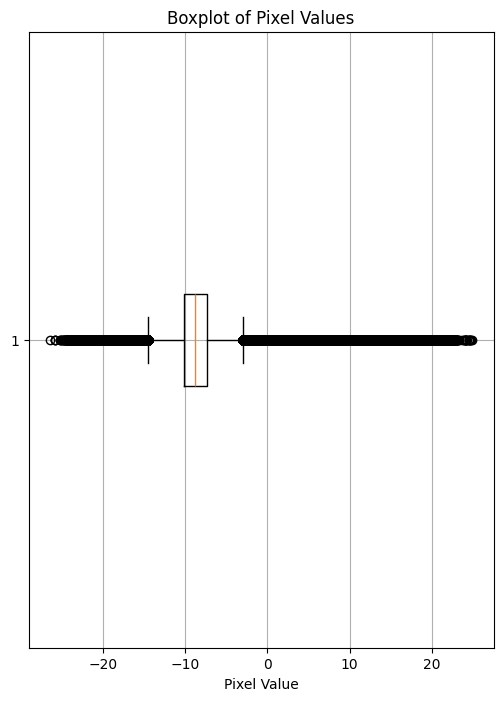

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Đường dẫn tới file .npy
file_path = '/mnt/storage/huyekgis/brios/data2/numpy_data/vh.npy'

# Đọc dữ liệu từ file .npy
image_data = np.load(file_path)

# Xử lý dữ liệu nếu có NaN
valid_data = image_data[~np.isnan(image_data)]

# Vẽ histogram để phân bố giá trị pixel
plt.figure(figsize=(10, 6))
plt.hist(valid_data.flatten(), bins=100, color='skyblue', edgecolor='black', density='kde')
plt.title('Histogram of Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Vẽ boxplot để xem phân vị của giá trị pixel
plt.figure(figsize=(6, 8))
plt.boxplot(valid_data.flatten(), vert=False)
plt.title('Boxplot of Pixel Values')
plt.xlabel('Pixel Value')
plt.grid(True)
plt.show()


Describe statistic

In [10]:
# Đọc dữ liệu từ file .npy
image_data = np.load(file_path)

# Lọc bỏ các giá trị NaN (nếu có)
valid_data = image_data[~np.isnan(image_data)].flatten()

# Tính toán các thông số mô tả dữ liệu
data_description = {
    'Mean': np.mean(valid_data),
    'Median': np.median(valid_data),
    'Min': np.min(valid_data),
    'Max': np.max(valid_data),
    'Standard Deviation': np.std(valid_data),
    'Q1 (25%)': np.percentile(valid_data, 25),
    'Q3 (75%)': np.percentile(valid_data, 75),
}

# In ra mô tả dữ liệu
for key, value in data_description.items():
    print(f"{key}: {value}")


Mean: -8.835507976866648
Median: -8.770246820335524
Min: -26.452571086783394
Max: 24.921713579762407
Standard Deviation: 3.205005705538525
Q1 (25%): -10.162432794224895
Q3 (75%): -7.300469251438548


In [5]:
import numpy as np

In [6]:
a = [{"deltas": [0.0, 0.0, 0.0], "masks": 1, "values": [-10.9921875, 2.44140625, 0.6591796875], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 1, "values": [-9.6953125, 2.548828125, 0.6591796875], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 1, "values": [-9.21875, 2.57421875, 0.2225341796875], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 0, "values": [-8.9296875, 2.583984375, 0.18603515625], "eval_masks": 2}, {"deltas": [16.0, 16.0, 32.0], "masks": 1, "values": [-8.65625, 2.62109375, 0.1583251953125], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 1, "values": [-8.1171875, 2.685546875, 0.177001953125], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 0, "values": [-7.7109375, 2.740234375, 0.299072265625], "eval_masks": 2}, {"deltas": [16.0, 16.0, 32.0], "masks": 1, "values": [-8.21875, 2.642578125, 0.299072265625], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 0, "values": [-7.83203125, 2.669921875, np.nan], "eval_masks": 0}, {"deltas": [16.0, 16.0, 32.0], "masks": 1, "values": [-7.51953125, 2.693359375, 0.52197265625], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 1, "values": [-7.1796875, 2.75, 0.50244140625], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 1, "values": [-7.69140625, 2.69140625, 0.48681640625], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 0, "values": [-8.5625, 2.60546875, np.nan], "eval_masks": 0}, {"deltas": [16.0, 16.0, 32.0], "masks": 1, "values": [-9.3203125, 2.505859375, 0.446533203125], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 1, "values": [-9.1953125, 2.4921875, 0.446533203125], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 0, "values": [-8.8671875, 2.482421875, np.nan], "eval_masks": 0}, {"deltas": [16.0, 16.0, 32.0], "masks": 0, "values": [-8.6875, 2.478515625, np.nan], "eval_masks": 0}, {"deltas": [16.0, 16.0, 48.0], "masks": 0, "values": [-11.0625, 2.412109375, np.nan], "eval_masks": 0}, {"deltas": [16.0, 16.0, 64.0], "masks": 1, "values": [-13.71875, 2.376953125, 0.175537109375], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 1, "values": [-15.53125, 2.392578125, 0.1719970703125], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 1, "values": [-14.8984375, 2.40625, 0.2120361328125], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 0, "values": [-13.03125, 2.466796875, 0.2578125], "eval_masks": 2}, {"deltas": [16.0, 16.0, 32.0], "masks": 0, "values": [-11.7578125, 2.486328125, np.nan], "eval_masks": 0}, {"deltas": [16.0, 16.0, 48.0], "masks": 0, "values": [-10.578125, 2.53515625, np.nan], "eval_masks": 0}, {"deltas": [16.0, 16.0, 64.0], "masks": 0, "values": [-10.09375, 2.533203125, np.nan], "eval_masks": 0}, {"deltas": [16.0, 16.0, 80.0], "masks": 0, "values": [-10.0625, 2.482421875, np.nan], "eval_masks": 0}, {"deltas": [16.0, 16.0, 96.0], "masks": 0, "values": [-10.421875, 2.4453125, np.nan], "eval_masks": 0}, {"deltas": [16.0, 16.0, 112.0], "masks": 0, "values": [-10.6640625, 2.4140625, np.nan], "eval_masks": 0}, {"deltas": [16.0, 16.0, 128.0], "masks": 0, "values": [-10.6171875, 2.4296875, np.nan], "eval_masks": 0}, {"deltas": [16.0, 16.0, 144.0], "masks": 0, "values": [-10.2578125, 2.43359375, np.nan], "eval_masks": 0}, {"deltas": [16.0, 16.0, 160.0], "masks": 1, "values": [-10.1640625, 2.431640625, 0.7158203125], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 1, "values": [-9.1953125, 2.515625, 0.7158203125], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 0, "values": [-9.484375, 2.54296875, np.nan], "eval_masks": 0}, {"deltas": [16.0, 16.0, 32.0], "masks": 0, "values": [-10.390625, 2.5703125, np.nan], "eval_masks": 0}, {"deltas": [16.0, 16.0, 48.0], "masks": 1, "values": [-12.2578125, 2.51953125, 0.1534423828125], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 0, "values": [-12.4140625, 2.568359375, 0.1973876953125], "eval_masks": 2}, {"deltas": [16.0, 16.0, 32.0], "masks": 1, "values": [-11.265625, 2.677734375, 0.2763671875], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 1, "values": [-9.4453125, 2.76171875, 0.445068359375], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 0, "values": [-9.4765625, 2.705078125, 0.445068359375], "eval_masks": 2}, {"deltas": [16.0, 16.0, 32.0], "masks": 1, "values": [-10.09375, 2.595703125, 0.59423828125], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 1, "values": [-11.28125, 2.49609375, 0.59423828125], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 1, "values": [-11.4140625, 2.484375, 0.88720703125], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 1, "values": [-11.4375, 2.484375, 0.86572265625], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 1, "values": [-11.4453125, 2.421875, 0.81884765625], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 0, "values": [-11.3125, 2.333984375, np.nan], "eval_masks": 0}, {"deltas": [16.0, 16.0, 32.0], "masks": 1, "values": [-11.2421875, 2.240234375, 0.52587890625], "eval_masks": 0}]


In [7]:
a[::-1]

[{'deltas': [16.0, 16.0, 32.0],
  'masks': 1,
  'values': [-11.2421875, 2.240234375, 0.52587890625],
  'eval_masks': 0},
 {'deltas': [16.0, 16.0, 16.0],
  'masks': 0,
  'values': [-11.3125, 2.333984375, nan],
  'eval_masks': 0},
 {'deltas': [16.0, 16.0, 16.0],
  'masks': 1,
  'values': [-11.4453125, 2.421875, 0.81884765625],
  'eval_masks': 0},
 {'deltas': [16.0, 16.0, 16.0],
  'masks': 1,
  'values': [-11.4375, 2.484375, 0.86572265625],
  'eval_masks': 0},
 {'deltas': [16.0, 16.0, 16.0],
  'masks': 1,
  'values': [-11.4140625, 2.484375, 0.88720703125],
  'eval_masks': 0},
 {'deltas': [16.0, 16.0, 16.0],
  'masks': 1,
  'values': [-11.28125, 2.49609375, 0.59423828125],
  'eval_masks': 0},
 {'deltas': [16.0, 16.0, 32.0],
  'masks': 1,
  'values': [-10.09375, 2.595703125, 0.59423828125],
  'eval_masks': 0},
 {'deltas': [16.0, 16.0, 16.0],
  'masks': 0,
  'values': [-9.4765625, 2.705078125, 0.445068359375],
  'eval_masks': 2},
 {'deltas': [16.0, 16.0, 16.0],
  'masks': 1,
  'values': [-9.

In [10]:
b = [{"deltas": [0.0, 0.0, 0.0], "masks": 1, "values": [-11.2421875, 2.240234375, 0.52587890625], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 0, "values": [-11.3125, 2.333984375, NaN], "eval_masks": 0}, {"deltas": [16.0, 16.0, 32.0], "masks": 1, "values": [-11.4453125, 2.421875, 0.81884765625], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 1, "values": [-11.4375, 2.484375, 0.86572265625], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 1, "values": [-11.4140625, 2.484375, 0.88720703125], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 1, "values": [-11.28125, 2.49609375, 0.59423828125], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 1, "values": [-10.09375, 2.595703125, 0.59423828125], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 0, "values": [-9.4765625, 2.705078125, 0.445068359375], "eval_masks": 2}, {"deltas": [16.0, 16.0, 32.0], "masks": 1, "values": [-9.4453125, 2.76171875, 0.445068359375], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 1, "values": [-11.265625, 2.677734375, 0.2763671875], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 0, "values": [-12.4140625, 2.568359375, 0.1973876953125], "eval_masks": 2}, {"deltas": [16.0, 16.0, 32.0], "masks": 1, "values": [-12.2578125, 2.51953125, 0.1534423828125], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 0, "values": [-10.390625, 2.5703125, NaN], "eval_masks": 0}, {"deltas": [16.0, 16.0, 32.0], "masks": 0, "values": [-9.484375, 2.54296875, np.nan], "eval_masks": 0}, {"deltas": [16.0, 16.0, 48.0], "masks": 1, "values": [-9.1953125, 2.515625, 0.7158203125], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 1, "values": [-10.1640625, 2.431640625, 0.7158203125], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 0, "values": [-10.2578125, 2.43359375, NaN], "eval_masks": 0}, {"deltas": [16.0, 16.0, 32.0], "masks": 0, "values": [-10.6171875, 2.4296875, NaN], "eval_masks": 0}, {"deltas": [16.0, 16.0, 48.0], "masks": 0, "values": [-10.6640625, 2.4140625, NaN], "eval_masks": 0}, {"deltas": [16.0, 16.0, 64.0], "masks": 0, "values": [-10.421875, 2.4453125, NaN], "eval_masks": 0}, {"deltas": [16.0, 16.0, 80.0], "masks": 0, "values": [-10.0625, 2.482421875, NaN], "eval_masks": 0}, {"deltas": [16.0, 16.0, 96.0], "masks": 0, "values": [-10.09375, 2.533203125, NaN], "eval_masks": 0}, {"deltas": [16.0, 16.0, 112.0], "masks": 0, "values": [-10.578125, 2.53515625, NaN], "eval_masks": 0}, {"deltas": [16.0, 16.0, 128.0], "masks": 0, "values": [-11.7578125, 2.486328125, NaN], "eval_masks": 0}, {"deltas": [16.0, 16.0, 144.0], "masks": 0, "values": [-13.03125, 2.466796875, 0.2578125], "eval_masks": 2}, {"deltas": [16.0, 16.0, 160.0], "masks": 1, "values": [-14.8984375, 2.40625, 0.2120361328125], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 1, "values": [-15.53125, 2.392578125, 0.1719970703125], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 1, "values": [-13.71875, 2.376953125, 0.175537109375], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 0, "values": [-11.0625, 2.412109375, NaN], "eval_masks": 0}, {"deltas": [16.0, 16.0, 32.0], "masks": 0, "values": [-8.6875, 2.478515625, NaN], "eval_masks": 0}, {"deltas": [16.0, 16.0, 48.0], "masks": 0, "values": [-8.8671875, 2.482421875, NaN], "eval_masks": 0}, {"deltas": [16.0, 16.0, 64.0], "masks": 1, "values": [-9.1953125, 2.4921875, 0.446533203125], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 1, "values": [-9.3203125, 2.505859375, 0.446533203125], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 0, "values": [-8.5625, 2.60546875, NaN], "eval_masks": 0}, {"deltas": [16.0, 16.0, 32.0], "masks": 1, "values": [-7.69140625, 2.69140625, 0.48681640625], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 1, "values": [-7.1796875, 2.75, 0.50244140625], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 1, "values": [-7.51953125, 2.693359375, 0.52197265625], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 0, "values": [-7.83203125, 2.669921875, NaN], "eval_masks": 0}, {"deltas": [16.0, 16.0, 32.0], "masks": 1, "values": [-8.21875, 2.642578125, 0.299072265625], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 0, "values": [-7.7109375, 2.740234375, 0.299072265625], "eval_masks": 2}, {"deltas": [16.0, 16.0, 32.0], "masks": 1, "values": [-8.1171875, 2.685546875, 0.177001953125], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 1, "values": [-8.65625, 2.62109375, 0.1583251953125], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 0, "values": [-8.9296875, 2.583984375, 0.18603515625], "eval_masks": 2}, {"deltas": [16.0, 16.0, 32.0], "masks": 1, "values": [-9.21875, 2.57421875, 0.2225341796875], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 1, "values": [-9.6953125, 2.548828125, 0.6591796875], "eval_masks": 0}, {"deltas": [16.0, 16.0, 16.0], "masks": 1, "values": [-10.9921875, 2.44140625, 0.6591796875], "eval_masks": 0}]

NameError: name 'NaN' is not defined

# Preprocessing Test

In [2]:
import os 
import rasterio
import numpy as np 
from datetime import datetime, timedelta

In [3]:
# test ok
def count_nans_and_cloudmask(ndvi_data, cloudmask):
    total_nans = np.sum(np.isnan(ndvi_data))
    total_cloudmask_ones = np.sum(cloudmask==1)
    return total_nans, total_cloudmask_ones

In [4]:
# test ok
def check_nan_cloudmask(ndvi_data, cloudmask):
    nan_idx = np.argwhere(np.isnan(ndvi_data))
    print(nan_idx)
    total_nans, total_ones = count_nans_and_cloudmask(ndvi_data, cloudmask)
    print(f'total nan in ndvi_data == {total_nans}')
    print(f'total value 1 in cloudmask == {total_ones}')

In [5]:
arrtest = np.array([[[np.nan, 1, 1], [np.nan, np.nan, np.nan], [1,1,1]], [[np.nan, 1, 1], [2, 3, np.nan], [np.nan,1,1]]])
cm = np.array([[[1,0,0], [1,1,1], [0,0,0]],[[1,0,0], [0,0,1], [1,0,0]]])

In [6]:
arrtest.shape

(2, 3, 3)

In [7]:
check_nan_cloudmask(arrtest, cm)

[[0 0 0]
 [0 1 0]
 [0 1 1]
 [0 1 2]
 [1 0 0]
 [1 1 2]
 [1 2 0]]
total nan in ndvi_data == 7
total value 1 in cloudmask == 7


In [8]:
# test ok
def process_cloudmask(ndvi_data, cloud_percentage=0.1):
    # tao cloud_mask tuong ung voi form cua ndvi_data
    ndvi_timeseries = ndvi_data.reshape((ndvi_data.shape[0] * ndvi_data.shape[1], ndvi_data.shape[2]))
    cloudmask_data = np.zeros((ndvi_timeseries.shape[0], ndvi_timeseries.shape[1]))
    nan_index = np.argwhere(np.isnan(ndvi_timeseries))
    print(nan_index)
    cloudmask_data[nan_index[:,0], nan_index[:,1]] = 1
    
    # tim tap hop cac index cloudmask == 0 (ko co may)
    cloud_index = np.argwhere(cloudmask_data == 0)
    n_total_clouds = len(cloud_index) # tinh tong so vi tri khong co may
    n_subset = int(cloud_percentage * n_total_clouds)
    
    # chon ngau nhien cac vi tri trong cac anh de mask lam valid data
    if n_subset > 0: 
        val_index = cloud_index[np.random.choice(n_total_clouds, n_subset, replace=False)]
        for idx in val_index:
            cloudmask_data[idx[0], idx[1]] = 2

    # w, h, timesteps = cloudmask_data.shape
    # n_samples = w * h
    # cloudmask_data = cloudmask_data.reshape(n_samples, timesteps)

    return cloudmask_data, ndvi_timeseries

In [11]:
def process_ndvi(folder_path, output_path=None, output_cloudmask=None):
    missing_dates = ['2023-01-05', '2023-02-06', '2023-02-14', '2023-03-26',
                    '2023-04-03', '2023-04-11', '2023-04-19', '2023-04-27']
    
    available_files = [file for file in os.listdir(folder_path) if file.endswith('.tif')]
    available_dates = sorted(
        datetime.strptime(f.split('_')[1].split('.')[0], "%Y-%m-%d") for f in available_files
    )
    
    with rasterio.open(os.path.join(folder_path, available_files[0])) as src:
        height, width = src.shape
    
    timeseries = []
    
    start_date = available_dates[0]
    end_date = available_dates[-1]
    current_date = start_date
    
    while current_date <= end_date:
        date_str = current_date.strftime('%Y-%m-%d')
        file_path = os.path.join(folder_path, f'ndvi8days_{date_str}.tif')
        
        if date_str in missing_dates or not os.path.exists(file_path):
            null_arr = np.full((height, width), np.nan)
            timeseries.append(null_arr)
            
        else:
            with rasterio.open(file_path) as src: 
                timeseries.append(src.read(1))
        
        current_date += timedelta(days=8)
    
    ndvi_data = np.stack(timeseries, axis=0).transpose(1, 2, 0)
    cloudmask, ndvi_timeseries = process_cloudmask(ndvi_data)

    return cloudmask, ndvi_timeseries

In [17]:
cloudmask, ndvi_data = process_ndvi('/mnt/storage/huyekgis/brios/data2/ndvi_8days/')

[[     0      8]
 [     0     12]
 [     0     15]
 ...
 [160739     35]
 [160739     39]
 [160739     40]]


In [18]:
# test ok
def create_areamask(rvi_data, vh_data):
    area_mask = np.ones(rvi_data.shape[0], dtype=np.int8)
    
    nan_rvi_indices = np.isnan(rvi_data)
    nan_vh_indices = np.isnan(vh_data)
    
    area_mask[np.any(nan_rvi_indices | nan_vh_indices, axis=1)] = 0
    
    return area_mask

In [19]:
def process_sar(folder_path, output_rvi_path=None, output_vh_path=None, output_areamask=None):
    available_files = sorted([file for file in os.listdir(folder_path) if file.endswith('.tif')])
    
    with rasterio.open(os.path.join(folder_path, available_files[0])) as src:
        height, width = src.shape
        
    rvi_timeseries = []
    vh_timeseries = []
    
    for file_name in available_files:
        file_path = os.path.join(folder_path, file_name)
        with rasterio.open(file_path) as src:
            rvi_timeseries.append(src.read(1))
            vh_timeseries.append(src.read(2))
            
    rvi_data = np.stack(rvi_timeseries, axis=0).transpose(1, 2, 0)
    vh_data = np.stack(vh_timeseries, axis=0).transpose(1, 2, 0)
    
    x, y, time = rvi_data.shape
    rvi_data = rvi_data.reshape(x * y, time)
    vh_data = vh_data.reshape(x * y, time)
    
    areamask = create_areamask(rvi_data, vh_data)
    return rvi_data, vh_data, areamask
    

In [20]:
rvi_data, vh_data, areamask = process_sar('/mnt/storage/huyekgis/brios/data2/rvi_8days')

In [22]:
print(f'ndvi_data shape = {ndvi_data.shape}')
print(f'rvi_data shape = {rvi_data.shape}')
print(f'cloudmask shape = {cloudmask.shape}')
print(f'areamask shape = {areamask.shape}')

ndvi_data shape = (160740, 46)
rvi_data shape = (160740, 46)
cloudmask shape = (160740, 46)
areamask shape = (160740,)


In [23]:
ndvi_data[0, :]

array([0.53256702, 0.53256702, 0.2135669 , 0.19188051, 0.18169583,
       0.18169583, 0.30206379, 0.30206379,        nan, 0.48914167,
       0.44397563, 0.40651801,        nan, 0.40032068, 0.40032068,
              nan,        nan,        nan, 0.16002019, 0.18298516,
       0.23901394, 0.27701148,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.60286868, 0.60286868,        nan,        nan, 0.23639192,
       0.27515152, 0.33769777, 0.31934032, 0.31934032, 0.41491738,
       0.41491738, 0.67754507, 0.66779661, 0.61542034,        nan,
       0.52324474])

In [38]:
cloudmask[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0.])

In [39]:
np.sum(cloudmask[0] == 1)

np.int64(16)

In [25]:
areamask[0]

np.int8(0)

In [32]:
n_timesteps = 46
n_samples = ndvi_data.shape[0]

In [40]:
# datanum
datanum = np.full(n_samples, n_timesteps, dtype=np.int8)
print(datanum)
for i in range(n_samples):
    datanum[i] -= np.sum(cloudmask[i] == 1)

print(f"DATANUM after adjustment: {datanum}")

# idx
idx = np.argwhere((areamask != 0) & (datanum > 25)).flatten()
train_size = int(len(idx)* 1.0) 

train_index = np.random.choice(idx, size=train_size, replace=False)

[46 46 46 ... 46 46 46]
DATANUM after adjustment: [30 30 30 ... 25 25 25]


In [35]:
datanum.shape

(160740,)

In [26]:
def cal_timestep(time, mask):
    """calculate timestep (between step t to step t-i nearest without cloud)

    Args:
        time (_type_): _description_
        mask (_type_): _description_

    Returns:
        deltaT: timestep
    """
    deltaT = time.copy()
    for i in range(len(time)):
        T_time0 = time[i]
        if i != 0:
            for k in range(i - 1, -1, -1):
                T_time1 = time[k]
                if mask[k] == 1:
                    T_time1 = time[k]
                    break

            T = T_time0-T_time1
        else:
            T = 0

        deltaT[i] = T

    return deltaT

In [27]:

def generate_random_data(shape):
    """Generates random data to simulate GEO TIFF data."""
    return np.random.rand(*shape)


In [41]:
trainmask = np.zeros(n_samples)
trainmask[train_index] = 1

In [50]:
ndvi_data0 = ndvi_data
vh_data0 = vh_data
rvi_data0 = rvi_data
cloudmask_arr = cloudmask
trainmask_arr = trainmask

In [53]:
train_index0 = np.where(trainmask_arr == 1)[0]

In [64]:
len(np.where(trainmask_arr==1)[0])

92388

In [69]:
# data Train
ndvi_data_train = ndvi_data0[train_index0]
vh_data_train = vh_data0[train_index0]
rvi_data_train = rvi_data0[train_index0]

# cloudmask Train
cloudmask_train = cloudmask_arr
mask_train = np.where(cloudmask_train == 0, 1, 0)
evalmask_train = np.where(cloudmask_train == 2, 1, 0)

print(ndvi_data_train[0])
print(mask_train[0])
print(evalmask_train[0])

[0.65930408 0.65930408 0.22252011 0.18604651 0.15833746 0.17697336
 0.29906541 0.29906541        nan 0.52188939 0.50244653 0.48672566
        nan 0.44658494 0.44658494        nan        nan        nan
 0.17556411 0.17203043 0.21208267 0.25777203        nan        nan
        nan        nan        nan        nan        nan        nan
 0.71576226 0.71576226        nan        nan 0.15349226 0.19736223
 0.27629232 0.4451282  0.4451282  0.59409595 0.59409595 0.8870303
 0.86551636 0.81895578        nan 0.52582669]
[1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1
 0 1 1 1 1 1 1 0 1]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0]


In [70]:
feature_num = 3
time = np.arange(1, 369, 8)

In [79]:
traindatasets_valuesF = np.empty((n_timesteps, 3, 0),dtype=np.float16)
traindatasets_evalmaskF = np.empty((n_timesteps, 0),dtype=np.int8)
traindatasets_maskF = np.empty((n_timesteps, 0),dtype=np.int8)
traindatasets_deltaF = np.empty((n_timesteps, 3, 0),dtype=np.int8)
traindatasets_deltaBF = np.empty((n_timesteps, 3, 0),dtype=np.int8)

In [76]:
traindatasets_valuesF

array([], shape=(46, 3, 0), dtype=float16)

In [ ]:
# gen time interval for training forward
delta_train_f = np.zeros((len(train_index0), n_timesteps))
for i in range(len(train_index0)):
    maskone = mask_train[i]
    done = cal_timestep(time, maskone)
    delta_train_f[i] = done
    
# gen time interval for training backward
delta_train_b = np.zeros((len(train_index0), n_timesteps))
for i in range(len(train_index0)):
    maskone = mask_train[0,::-1]
    done = cal_timestep(time, maskone)
    delta_train_b[i] = done

In [89]:
vh_data.shape

(160740, 46)

In [91]:
# gen training dataset 
train_data_values = np.zeros((n_timesteps, feature_num, len(train_index0)),dtype=np.float16)
for i in range(n_timesteps):
    for k in range(len(train_index0)):
        train_data_values[i, 0, k] = vh_data[k, i]
        train_data_values[i, 1, k] = rvi_data[k, i]
        train_data_values[i, 2, k] = ndvi_data[k, i]
traindatasets_valuesF = np.concatenate((traindatasets_valuesF, train_data_values), axis=2)
        

In [ ]:
# gen evalmask
train_data_eval = np.zeros((n_timesteps, ))